## Simulate and fit DCE-MRI

In [3]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import dce_fit, relaxivity, signal_models, water_ex_models, aifs, pk_models
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Simulate and fit noisy time-concentration data

Wall time: 40.4 ms
parameter: value (ground truth)
vp: 0.019733 (0.020000)
ps: 0.049252 (0.050000)
ve: 0.208537 (0.200000)
fp: 15.132366 (15.000000)
delay: 4.981218 (5.000000)


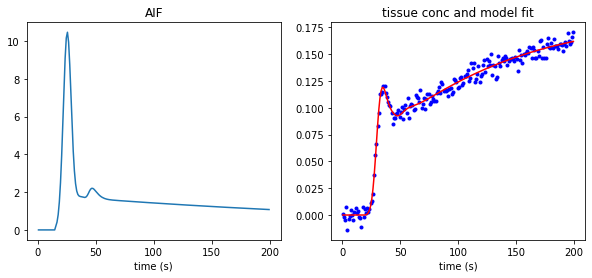

In [81]:
# define timepoints
dt = 1.
t = np.arange(0,200)*dt + dt/2

# define AIF, pharmacokinetic model and noise level
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars_ground_truth = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 15, 'delay': 5}
pk_model_ground_truth = pk_models.tcxm(t, aif, fixed_delay=None) # <-- CHANGE THE MODEL HERE
noise = 0.005

# generate "measured" concentration then add noise
c_t, _c_cp, _c_e = pk_model_ground_truth.conc(**pk_pars_ground_truth)
c_t += np.random.normal(loc = 0., scale = noise, size = c_t.shape)

# fit measured concentration using the same pharmacokinetic model
pk_model = pk_models.tcxm(t, aif, fixed_delay=None) # <-- CHANGE THE MODEL HERE
pk_pars_0 = [{'vp': 0.01, 'ps': 1e-2, 've': 0.5, 'fp': 5, 'delay': 0}, # optionally specify multiple sets of starting values to find global minimum 
             {'vp': 0.1, 'ps': 1e-4, 've': 0.025, 'fp': 5, 'delay': 5}
            ]
%time pk_pars_fit, c_t_fit = dce_fit.conc_to_pkp(c_t, pk_model, pk_pars_0=pk_pars_0)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars_ground_truth[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, c_t, 'b.', t, c_t_fit, 'r-');
ax[1].set_xlabel('time (s)');
ax[1].set_title('tissue conc and model fit');

### Simulate and fit signal-time data

Start by setting ground-truth acquisition parameters

In [88]:
# ground-truth acquisition properties
dt = 1.
t = np.arange(0,200)*dt + dt/2
k_tissue = 1.0 # B1+ error
tr, fa_rad, te = 4e-3, 15.*(np.pi/180.), 1.5e-3
signal_model = signal_models.spgr(tr, fa_rad, te)
noise = 3

# ground-truth tissue properties
R10_tissue, R10_vif = 1./0.8, 1./1.7
hct = 0.42
aif = aifs.parker(hct=0.42, t_start=15.)
pk_pars_ground_truth = {'vp': 0.02, 'ps': 5e-2, 've': 0.2, 'fp': 15, 'delay': 5}
pk_model = pk_models.tcxm(t, aif, dt_interp_request=0.1, fixed_delay=None) # <-- CHANGE THE MODEL HERE
c_to_r_model = relaxivity.c_to_r_linear(r1=5.0, r2 = 0)
water_ex_model = water_ex_models.fxl()

# create the measured AIF (assume this to be the true aif at the measured time points; no noise added)
c_ap = aif.c_ap(t)
aif_measured = aifs.patient_specific(t, c_ap)

# processing parameters (assume AIF and T10 are accurately known)
baseline_idx = np.arange(15)
pk_model_fit = pk_models.tcxm(t, aif_measured, dt_interp_request=0.1, fixed_delay=None)
c_to_r_model_fit = relaxivity.c_to_r_linear(r1=5.0, r2 = 0)
water_ex_model_fit = water_ex_models.fxl()
signal_model_fit = signal_model # use same signal model to simulate and fit data
k_tissue_fit = 1.0 # pretend we don't know about B1+ error

Now simulate the enhancement data and fit

Wall time: 405 ms
parameter: value (ground truth)
vp: 0.019024 (0.020000)
ps: 0.049693 (0.050000)
ve: 0.190760 (0.200000)
fp: 16.675436 (15.000000)
delay: 5.342892 (5.000000)


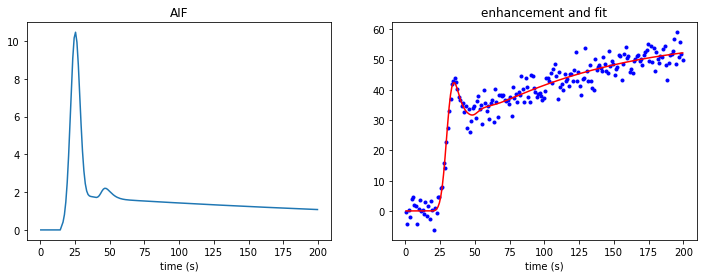

In [104]:
# simulate enhancement with noise
enh = dce_fit.pkp_to_enh(pk_pars_ground_truth, hct, k_tissue, R10_tissue, R10_vif, pk_model, c_to_r_model, water_ex_model, signal_model)
enh += np.random.normal(loc = 0., scale = noise, size = enh.shape)

# fit simulated enhancement
pk_pars_0 = [{'vp': 0.01, 'ps': 1e-4, 've': 0.05, 'fp': 5, 'delay': 0}, # optionally specify multiple sets of starting values to find global minimum 
             {'vp': 0.1, 'ps': 1e-4, 've': 0.05, 'fp': 5, 'delay': 8}
            ]
%time pk_pars_fit, enh_fit = dce_fit.enh_to_pkp(enh, hct, k_tissue_fit, R10_tissue, R10_vif, pk_model_fit, c_to_r_model_fit, water_ex_model_fit, signal_model_fit, pk_pars_0=pk_pars_0)

print("parameter: value (ground truth)")
[ print(f"{key}: {val:.6f} ({pk_pars_ground_truth[key]:.6f})") for key, val in pk_pars_fit.items() ]

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(t, aif.c_ap(t));
ax[0].set_xlabel('time (s)');
ax[0].set_title('AIF');
ax[1].plot(t, enh, 'b.', t, enh_fit, 'r-')
ax[1].set_xlabel('time (s)');
ax[1].set_title('enhancement and fit');